# Introduction

Ensemble ML model for directly modeling the URANS non-linear closure terms
* Input:  sequence of flow variables
* Output: time derivate of variables
* **Flow field**: Various SST cases
* **NN framework**: PyTorch
* **Data script**: [DataAcqu_LSTM.ipynb](DataAcqu_LSTM.ipynb)

# Import libraries

In [1]:
# import all python, pytorch, and ML libraries, classes and functions
from NN_funcs import *

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Start main

## Set parameters

In [2]:
# Data type
casenum         = [1]        # dataset case number(s) (see DataAcqu_LSTM.ipynb or data_funcs.py)
# parameters used for data acquisition
target_T        = 1          # target time period for sampling frequency
seq_len_T       = 64         # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy      = True       # normalize inputs to dimension of energy and non-dimensionalize both i/p & o/p using total energy at initial state
interpIO        = True       # interpolate data so that seq dt are same
set_dt_seq      = True       # set dt for `interpIO` such that time length of `seq_len` data points = dt_T time period
dt_T            = 1.0        # dt for interpIO
if set_dt_seq:
    seq_len     = np.max([int(dt_T/dt_target), 1])  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T                         # sequence length (lag time) for LSTM input

add_IP_time     = False      # add time info as an additional input
add_IP_ke_pe_T  = False      # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn    = False      # add Frh and Gn as additional inputs

Ntrainper       = 0.9        # number of training data (%)

# Hyperparameters
# data
n_val         = 0.1          # validation data (ratio)
n_inputs      = 4            # number of inputs
n_outputs     = 4            # number of outputs
# network architecture
model_name    = 'LSTM'       # model name: 'SingleMLP' 'ResNet' 'DenseNet' 'LSTM'
# dense layers
n_per_layer   = 15           # number of neurons on all hidden dense layers (manually update model if needed)
n_layers      = 1            # number of dense layers - ResNet, DenseNet
drp_in        = 0            # probability value for input dropout 
drp_hd        = 0            # probability value for hidden layer dropout
# RNN/LSTM layers
n_lstm_layers = 4            # number of layers - LSTM blocks/cells
hidden_size   = 10           # hidden state size of LSTM cell
# other settings
lkyReLU_alpha = 0.1          # slope of leakyReLU
lrate         = 1e-3         # learning rate
reg_type      = 'None'       # manual weight regularization 'L1' 'L2' 'None'
reg_factor    = 1e-6         # regularization factor
# training parameters
nepoch        = 10         # number of training epochs (additional for restart runs)
batch_size    = 10           # batch size
scaleData     = False        # scale data (e.g.: naive min-max scaling of I/O)

# Save NN model
HDdir         = '.'          # root dir of all data and models
saveNN        = True        # save the model, learning history
restartTrain  = False        # restart training
ensmbleTrain  = False        # restart training with ensemble (first restart training for a few epoch and figure out ensm_errval)
ensmb_errval  = 1.7e-6       # models with error below this will be used for ensemble. Choose manually based on original training curve
nepoch_in     = 4000         # nepoch of original (old) model
lrate_restart = 5e-4         # new lrate

# Device settings
disable_device  = True        # disable GPU?

In [3]:
# get casenames
casename     = [get_casename(i) for i in casenum]

# model filename
savefilename = f'{HDdir}/Data_models/SSTRANS_EnergyEqn_normEnergy{int(normEnergy)}_interpIO{int(interpIO)}'\
                f'_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):              # casename(s)
    savefilename = f'{savefilename}_{casename[i]}'
savefilename = f'{savefilename}_PyTModel_{model_name}_seqlen{seq_len}_nLSTMLayers{n_lstm_layers}_hiddensize{hidden_size}_'\
                f'nMLPLayers{n_layers}_nNeurons{n_per_layer}_batch{batch_size}_lr{lrate}_'\
                f'scaleData{scaleData}_nin{n_inputs}_Ntrain{Ntrainper}'
if ensmbleTrain or restartTrain:           # restart filename
    savefilename = f'{savefilename}_nepoch{nepoch_in}'
    lrate        = lrate_restart
    saveFnameRes =f'_restartEpoch{nepoch_in}_lr{lrate}'
else:
    savefilename = f'{savefilename}_nepoch{nepoch}'

# data filename
shuffledata  = False             # randomly shuffle training data or not
loaddatapath = f'{HDdir}/Data_training/RANSdata_shuffle{shuffledata}_in-Energy_LSTM_seqlen{seq_len}_'\
            f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
            f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):    # casename(s)
    loaddatapath = f'{loaddatapath}_{casename[i]}'
loaddatapath = f'{loaddatapath}_Ntrain{Ntrainper}.npz'

# ============cuda settings============
if not disable_device and (torch.cuda.is_available() or torch.backends.mps.is_available()):
    if torch.cuda.is_available():
        device_name = torch.device('cuda')
    else:
        device_name = torch.device("mps")
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')

Using the device: cpu


## Prepare the data: split training & testing

### Load full data and scale

In [4]:
npzfile = np.load(loaddatapath)
# !!!!!!!Make sure the datatype is float!!!!!!
train_IP = npzfile['datatrain_IP'].astype('float32')
train_OP = npzfile['datatrain_OP'].astype('float32')
# Test data is 30% of full data (to change use `DataAcqu*` code)
test_IP = npzfile['datatest_IP'].astype('float32')
test_OP = npzfile['datatest_OP'].astype('float32')
# varnames and time data for plotting
data_ip_varnames  = npzfile['data_ip_varnames']
data_op_varnames  = npzfile['data_op_varnames']
datatrain_time    = npzfile['datatrain_time']
datatest_time     = npzfile['datatest_time']

print(f'Number of samples for training:\t{train_IP.shape[0]}')
print(f'Number of samples for testing:\t{test_IP.shape[0]}')

if n_inputs != train_IP.shape[-1]:
    raise Exception(f'n_inputs ({n_inputs:,}) ~= # input of training samples from data ({train_IP.shape[-1]:,})')

# Scale data
if scaleData:
    train_IP, train_OP, test_IP, test_OP, input_scalar, output_scalar = get_scaleddataset(train_IP, train_OP, 
                                                                                          test_IP, test_OP, 
                                                                                          MinMaxScaler(), MinMaxScaler())

    # Save scaling measures (min-max)
    if saveNN:
        sclrArray = np.append(input_scalar.data_min_.reshape(n_inputs,1),input_scalar.data_max_.reshape(n_inputs,1),axis=1)
        sclrFname = loaddatapath[:-4]+'_input.txt'
        np.savetxt(sclrFname, sclrArray, fmt="%s")
        sclrArray = np.append(output_scalar.data_min_.reshape(n_outputs,1),output_scalar.data_max_.reshape(n_outputs,1),axis=1)
        sclrFname = loaddatapath[:-4]+'_output.txt'
        np.savetxt(sclrFname, sclrArray, fmt="%s")

# Send data to device
train_IP_d = torch.from_numpy(train_IP).to(device_name, non_blocking=False)
train_OP_d = torch.from_numpy(train_OP).to(device_name, non_blocking=False)
test_IP_d = torch.from_numpy(test_IP).to(device_name, non_blocking=False)
test_OP_d = torch.from_numpy(test_OP).to(device_name, non_blocking=False)

Number of samples for training:	1671
Number of samples for testing:	186


## Define the network

In [5]:
# original model
model = defNNmodel(model_name, n_inputs, n_outputs, seq_len, hidden_size, n_lstm_layers, n_layers, n_per_layer, drp_in, drp_hd, lkyReLU_alpha, device_name)

Multi-layer LSTM block + single dense layer: number of parameters =  13229


## Train the model

In [6]:
# ============cuda settings============
if (not ensmbleTrain) and (not restartTrain):
    model.train()
    print("Training from begining...")
    t = time.time()
    train_loss_history, val_loss_history, optimizer, epoch, loss = train_model(train_IP_d, train_OP_d, n_val, 
                                                                               batch_size, model, nepoch, lrate,
                                                                               reg_factor, reg_type, device_name)
    elpsdt = time.time() - t
else:
    # model
    optimizer = optim.NAdam(model.parameters(), lr=lrate)
    checkpoint = torch.load(savefilename+'_restart.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    nepoch += epoch
    loss = checkpoint['loss']
    model.train()
    # loss history
    loss_history = np.load(savefilename+'_epoch'+str(nepoch_in)+'_losshistory.npy')
    train_loss_history = tuple(loss_history[:,0].reshape(1, -1)[0])
    val_loss_history = tuple(loss_history[:,1].reshape(1, -1)[0])
    # re-start training
    if not ensmbleTrain:    # restart the training WITHOUT ensemble of model
        print(f"Restarting training from {epoch} epoch...")
        t = time.time()
        train_loss_history, val_loss_history, optimizer, epoch, loss = train_model(train_IP, train_OP, n_val, 
                                                                                   batch_size, model, nepoch, lrate,
                                                                                   reg_factor, reg_type, device_name,
                                                                                   epoch, train_loss_history, 
                                                                                   val_loss_history)    
    else:              # restart training WITH ensemble of model
        # ensemble model
        modelEnsmb = defNNmodel(model_name)
        modelEnsmb.load_state_dict(checkpoint['model_state_dict'])

        # re-start training
        print(f"Restarting training from {epoch} epoch and computing model ensemble...")
        t = time.time()
        train_loss_history, val_loss_history, optimizer, epoch, loss, ensmb_count = train_model_ensemble(train_IP, train_OP, n_val,
                                                                                            batch_size, model, modelEnsmb, ensmb_errval, nepoch,
                                                                                            lrate, reg_factor, reg_type, device_name,
                                                                                            epoch, train_loss_history, 
                                                                                            val_loss_history)
        print(f'Number of ensembles = {ensmb_count:,}')
    elpsdt = time.time() - t
    savefilename = f'{savefilename}{saveFnameRes}'

Training from begining...
Epoch =    1/10, dt = 2.048s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 1.565e-03, validation loss = 4.030e-04


In [7]:
print(f'Time elapsed for training model: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')
print(f'Final training MSE: {train_loss_history[-1]:4.3e} (RMSE: {math.sqrt(train_loss_history[-1]):4.3e})')
print(f'Final validation MSE: {val_loss_history[-1]:4.3e} (RMSE: {math.sqrt(val_loss_history[-1]):4.3e})')

Time elapsed for training model: 0 min 20.58 sec
Final training MSE: 5.182e-05 (RMSE: 7.198e-03)
Final validation MSE: 1.212e-04 (RMSE: 1.101e-02)


## Evaluate the model & prediction

* Make a separate dataloader for test dataset

In [8]:
# send model and everything to cpu for inference
if device_name.type == 'cuda' or device_name.type == 'mps':
    device_name = torch.device('cpu')
    model.to(device_name)   # for saving the model and plotting results
    model.device_name = device_name
model.eval()
n_testsamples = test_IP.shape[0]
temp_MLop = model( torch.from_numpy( np.array(test_IP) ) )
test_OP_ML = temp_MLop.detach().numpy()
mse = mean_squared_error(test_OP,test_OP_ML, multioutput='uniform_average')
msefull = mean_squared_error(test_OP,test_OP_ML, multioutput='raw_values')
print('Test MSE: %4.3e (RMSE: %4.3e)' % (mse, math.sqrt(mse)))

Test MSE: 1.977e-04 (RMSE: 1.406e-02)


## Save model

In [9]:
# send model and everything to cpu for saving
if device_name.type == 'cuda' or device_name.type == 'mps':
    device_name = torch.device('cpu')
    model.to(device_name)   # for saving the model and plotting results
    model.device_name = device_name

* Save Python version of model

In [10]:
if saveNN:
    modelpath = savefilename+'.pkl'
    torch.save(model.state_dict(), modelpath)

# # How to load the model
# model = MLP(n_inputs,nneurons,leakyReLU_alpha,n_outputs)
# model.load_state_dict(torch.load(modelpath))
# model.eval()

* Save ONNX version of model

In [11]:
# modelpath = savefilename+'.onnx'
# # set the model to inference mode
# model.eval() 
# # Let's create a dummy input tensor   # torch.randn(1, input_size, requires_grad=True)
# sample_input = torch.from_numpy( np.array( [test_IP[0,:]] ) )
# # convert model to ONNX format
# convert_ONNX(model, sample_input, modelpath, [data_ip_varnames[0]], [data_op_varnames[0]], verbose=False)

# # # How to load model and run:
# # See: https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

* Save full model for restart

In [12]:
if saveNN:
    modelpath = savefilename+'_restart.tar'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, modelpath)

# # How to load and restart training
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(modelpath)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

* Training & validation loss history

In [13]:
if saveNN:
    loss_history = np.append(np.asarray(train_loss_history).reshape(len(train_loss_history),1), 
                             np.asarray(val_loss_history).reshape(len(val_loss_history),1),axis=1)
    np.save(savefilename+'_epoch'+str(nepoch)+'_losshistory.npy',loss_history)

* Save model as C++ script

In [14]:
if saveNN:
    # Load a sample image
    _, test_dl = prepare_data(test_IP, test_OP, 0.9, batch_size)
    sample_input, sample_target = next(iter(test_dl))
    # run the tracing
    traced_script_module = torch.jit.trace(model, sample_input)  # NOTE:the model should be in cpu
    # save the converted model
    traced_script_module.save(savefilename+'_Cpp.pt')

## Plotting the results

### Plot learning curves

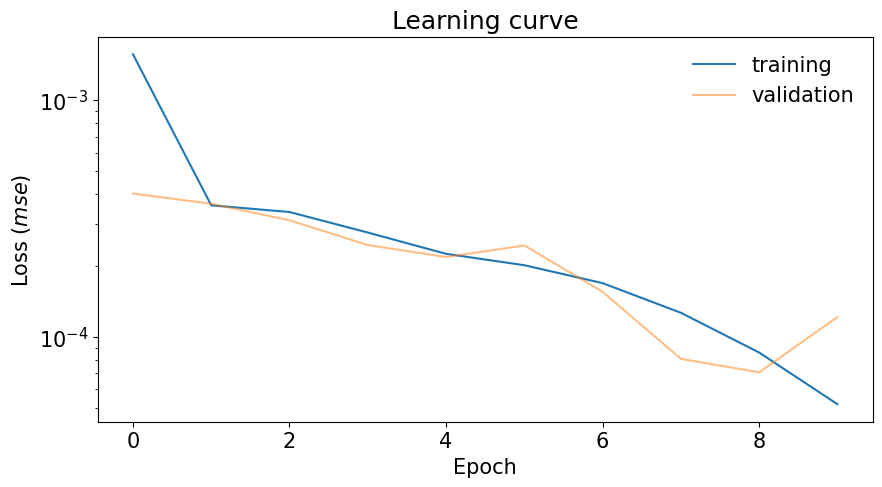

In [15]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 15})
plt.title('Learning curve')
plt.plot(train_loss_history, label='training')
plt.plot(val_loss_history, label='validation',alpha=0.5)
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel(r'Loss ($mse$)')
plt.legend(frameon=False);
# plt.savefig('Figs/learningCurves.png', bbox_inches='tight',dpi=200)

### Plot predicted output 
* (in scaled form if applicable)

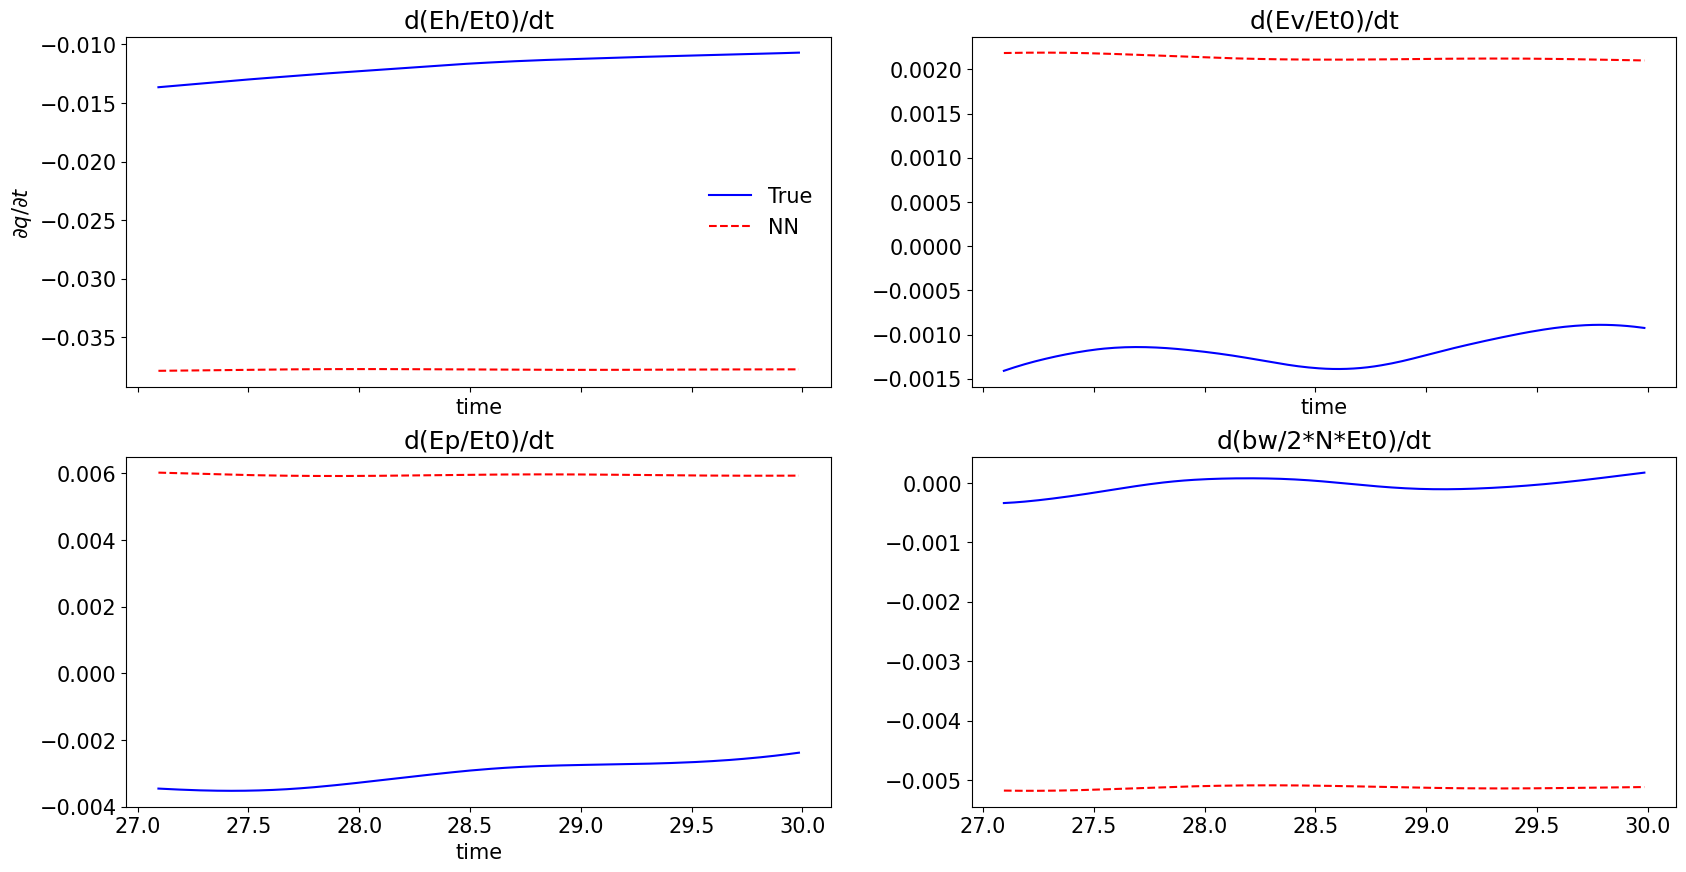

In [16]:
fig, axs = plt.subplots(2,2,figsize=(20,10), sharex=True)
axs = axs.ravel()
for i in range(n_outputs):
    axs[i].plot(datatest_time,test_OP[:,i],'b-', label='True')
    axs[i].plot(datatest_time,test_OP_ML[:,i],'r--', label='NN')
    axs[i].set_title(data_op_varnames[i])
axs[0].set_xlabel(r'time'); axs[1].set_xlabel(r'time'); axs[2].set_xlabel(r'time');
axs[0].set_ylabel(r'$\partial q/\partial t$')
axs[0].legend(frameon=False);
# plt.savefig('Figs/Py_testOP_scaled.png', bbox_inches='tight',dpi=100)